# Detector Calibration with Volumetric Persistence - Clean Version

This is a streamlined version of the detector calibration notebook with all the working functionality preserved and unnecessary parameter optimization removed.

## Features:
- Support for multiple data formats (Excel, CSV)
- **Area Under Curve (AUC) normalization** for source comparability
- Predefined radioactive source configurations
- Simple, working volumetric persistence peak detection
- Linear calibration with cross-validation
- Comprehensive visualization and analysis tools
- Quality assessment and poor detector identification

## Workflow:
1. **Setup**: Import modules and configure data paths
2. **Data Processing**: Load spectra, apply AUC normalization, and detect peaks using global parameters
3. **Calibration**: Perform linear calibration across all detectors
4. **Visualization**: Generate all analysis plots
5. **Export**: Save results

## New in this version:
- **AUC Normalization**: All spectra are automatically normalized by their area under the curve as the first preprocessing step. This makes different radioactive sources directly comparable while preserving relative peak intensities.

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import importlib
warnings.filterwarnings('ignore')

# Import our calibration modules
from calibration_core import (
    process_source_data,
    calibrate_detector_array,
    find_poor_detectors
)
import calibration_plots
importlib.reload(calibration_plots)  # Force reload to pick up changes
from calibration_plots import (
    plot_calibration_quality_overview,
    plot_single_detector_calibration,
    plot_combined_source_spectra,
    plot_3d_energy_spectrum,
    plot_2d_energy_heatmap
)
from source_config import (
    get_source_config,
    print_source_info,
    list_available_sources,
    GLOBAL_DETECTION_PARAMS
)

print("✅ Calibration modules loaded successfully!")
print("\n📊 Available radioactive sources:")
print_source_info()
print(f"\n🔧 Using global detection parameters with {len(GLOBAL_DETECTION_PARAMS['smoothing_range']) * len(GLOBAL_DETECTION_PARAMS['threshold_range']) * len(GLOBAL_DETECTION_PARAMS['prominence_range'])} parameter combinations")

✅ Calibration modules loaded successfully!

📊 Available radioactive sources:
  Sodium: 0.511 MeV - Na-22 - Positron emitter with 511 keV annihilation peak
  Cobalt: 1.170, 1.330 MeV - Co-60 - Two gamma rays at 1173 keV and 1332 keV
  Cesium: 0.662 MeV - Cs-137 - Single gamma ray at 662 keV
  Americium: 0.059 MeV - Am-241 - Low energy gamma ray at 59.5 keV
  Barium: 0.081, 0.356 MeV - Ba-133 - Multiple gamma rays, main peaks at 81 and 356 keV
  Europium: 0.122, 0.244, 0.344, 0.779, 0.964, 1.408 MeV - Eu-152 - Multiple gamma rays for energy calibration
  Manganese: 0.835 MeV - Mn-54 - Single gamma ray at 835 keV

🔧 Using global detection parameters with 126 parameter combinations


## 2. Configuration

Configure your calibration setup by specifying:
- Data file path and format
- Radioactive sources to use
- Sheet names (for Excel files) or file paths (for CSV files)

In [2]:
# =============================================================================
# CONFIGURATION SECTION - MODIFY THESE SETTINGS FOR YOUR DATA
# =============================================================================

# Data file configuration
DATA_FILE_PATH = "../DATI_Gullo1.xlsx/Dati_luglio.xlsx"  # Path to your data file
FILE_FORMAT = "excel"  # "excel" or "csv"

# Source configuration for Excel files (sheet mapping)
# Format: {source_name: sheet_name}
EXCEL_SHEET_MAPPING = {
    "Sodium": "Sodio I",
    "Cobalt": "Cobalto I", 
    "Cesium": "Cesio I"
}

# Source configuration for CSV files (file mapping)
# Format: {source_name: file_path}
CSV_FILE_MAPPING = {
    # "Sodium": "data/sodium_spectrum.csv",
    # "Cobalt": "data/cobalt_spectrum.csv",
    # "Cesium": "data/cesium_spectrum.csv"
}

# Settings
CALIBRATION_SETTINGS = {
    "cv_error_threshold": 0.1,  # Threshold for poor detector identification (MeV)
    "count_threshold": 100,      # Minimum count threshold for 3D plots
}

print("⚙️ Configuration loaded:")
print(f"   Data file: {DATA_FILE_PATH}")
print(f"   Format: {FILE_FORMAT}")
if FILE_FORMAT == "excel":
    print(f"   Sources: {list(EXCEL_SHEET_MAPPING.keys())}")
else:
    print(f"   Sources: {list(CSV_FILE_MAPPING.keys())}")
print(f"   CV error threshold: {CALIBRATION_SETTINGS['cv_error_threshold']} MeV")

⚙️ Configuration loaded:
   Data file: ../DATI_Gullo1.xlsx/Dati_luglio.xlsx
   Format: excel
   Sources: ['Sodium', 'Cobalt', 'Cesium']
   CV error threshold: 0.1 MeV


## 3. Data Processing

Load spectral data, apply Area Under Curve (AUC) normalization to make different sources comparable, and detect peaks using global volumetric persistence parameters for all configured sources.

**Preprocessing steps applied:**
1. **AUC Normalization**: Each spectrum is divided by its total area (sum of all counts) to normalize different source intensities
2. **Peak Detection**: Volumetric persistence-based peak detection with physics-based peak selection

In [3]:
# =============================================================================
# DEMONSTRATION: AUC Normalization Effect
# =============================================================================

# Let's demonstrate the effect of AUC normalization by loading raw data
# and showing the before/after comparison

print("📊 AUC Normalization Demonstration")
print("=" * 50)

# Force reload the module to pick up the fix
import importlib
import calibration_core
importlib.reload(calibration_core)

# Import normalization function (with fixed version)
from calibration_core import normalize_spectra_auc, load_data_from_excel

# Load raw data for one source to demonstrate normalization
try:
    # Use the correct sheet name from configuration
    sheet_name = EXCEL_SHEET_MAPPING["Cesium"]  # Should be "Cesio I"
    raw_spectra = load_data_from_excel(DATA_FILE_PATH, sheet_name)
    
    print(f"📋 Raw data info:")
    print(f"   Shape: {raw_spectra.shape}")
    print(f"   Data type: {raw_spectra.dtype}")
    print(f"   Min value: {np.min(raw_spectra)}")
    print(f"   Max value: {np.max(raw_spectra)}")
    
    # Test normalization step by step
    detector_idx = 0
    raw_spectrum = raw_spectra[:, detector_idx]
    total_area = np.sum(raw_spectrum)
    
    print(f"\n🔬 Sample detector {detector_idx} (Cesium source - {sheet_name}):")
    print(f"   Raw spectrum total area: {total_area:.0f} counts")
    print(f"   Peak value before normalization: {np.max(raw_spectrum):.0f}")
    
    # Now test the fixed function
    normalized_spectra = normalize_spectra_auc(raw_spectra)
    norm_spectrum = normalized_spectra[:, detector_idx]
    
    print(f"   Normalized spectrum total area: {np.sum(norm_spectrum):.10f}")
    print(f"   Peak value after normalization: {np.max(norm_spectrum):.8f}")
    print(f"   Normalized spectra data type: {normalized_spectra.dtype}")
    
    # Verify normalization worked correctly for all detectors
    all_areas = np.sum(normalized_spectra, axis=0)
    all_areas_are_one = np.allclose(all_areas, 1.0)
    
    print(f"\n🔍 Verification across all detectors:")
    print(f"   All normalized spectra have unit area: {all_areas_are_one}")
    print(f"   Sample of normalized areas: {all_areas[:5]}")
    print(f"   Area statistics: mean={np.mean(all_areas):.6f}, std={np.std(all_areas):.2e}")
    
    # Calculate normalization factors for all detectors
    raw_totals = np.sum(raw_spectra, axis=0)
    norm_factors = 1.0 / raw_totals
    
    print(f"\n📈 Normalization factors across all detectors:")
    print(f"   Mean normalization factor: {np.mean(norm_factors):.2e}")
    print(f"   Min normalization factor: {np.min(norm_factors):.2e}")
    print(f"   Max normalization factor: {np.max(norm_factors):.2e}")
    print(f"   Factor variation (std/mean): {np.std(norm_factors)/np.mean(norm_factors):.3f}")
    
    print(f"\n✅ AUC normalization is working correctly!")
    print(f"   This ensures fair comparison between different sources.")
    
except Exception as e:
    print(f"❌ Could not demonstrate normalization: {e}")
    import traceback
    traceback.print_exc()
    print(f"   Check that the data file exists at: {DATA_FILE_PATH}")
    print(f"   Available sheet mapping: {EXCEL_SHEET_MAPPING}")

📊 AUC Normalization Demonstration
📋 Raw data info:
   Shape: (2047, 128)
   Data type: int64
   Min value: 0
   Max value: 4049

🔬 Sample detector 0 (Cesium source - Cesio I):
   Raw spectrum total area: 613886 counts
   Peak value before normalization: 2217
   Normalized spectrum total area: 1.0000000000
   Peak value after normalization: 0.00361142
   Normalized spectra data type: float64

🔍 Verification across all detectors:
   All normalized spectra have unit area: True
   Sample of normalized areas: [1. 1. 1. 1. 1.]
   Area statistics: mean=1.000000, std=8.38e-17

📈 Normalization factors across all detectors:
   Mean normalization factor: 2.11e-06
   Min normalization factor: 1.02e-06
   Max normalization factor: 4.47e-06
   Factor variation (std/mean): 0.286

✅ AUC normalization is working correctly!
   This ensures fair comparison between different sources.
📋 Raw data info:
   Shape: (2047, 128)
   Data type: int64
   Min value: 0
   Max value: 4049

🔬 Sample detector 0 (Cesium 

In [15]:
# =============================================================================
# FORCE RELOAD ALL MODULES TO PICK UP CONFIGURATION CHANGES
# =============================================================================

print("🔄 Reloading all modules and configurations...")

# Force reload all modules to pick up changes
import importlib
import sys

# Reload core modules
import core
importlib.reload(core)

# Reload calibration modules  
import calibration_core
importlib.reload(calibration_core)

import calibration_plots
importlib.reload(calibration_plots)

import source_config
importlib.reload(source_config)

# Re-import everything after reload
from calibration_core import (
    process_source_data,
    calibrate_detector_array,
    find_poor_detectors,
    normalize_spectra_auc,
    load_data_from_excel
)

from calibration_plots import (
    plot_calibration_quality_overview,
    plot_single_detector_calibration,
    plot_combined_source_spectra,
    plot_3d_energy_spectrum,
    plot_2d_energy_heatmap
)

from source_config import (
    get_source_config,
    print_source_info,
    list_available_sources,
    GLOBAL_DETECTION_PARAMS
)

print("✅ All modules reloaded successfully!")
print(f"🔧 Updated detection parameters:")
print(f"   Threshold range: {GLOBAL_DETECTION_PARAMS['threshold_range']}")
print(f"   Prominence range: {GLOBAL_DETECTION_PARAMS['prominence_range']}")
print(f"   Parameter combinations: {len(GLOBAL_DETECTION_PARAMS['smoothing_range']) * len(GLOBAL_DETECTION_PARAMS['threshold_range']) * len(GLOBAL_DETECTION_PARAMS['prominence_range'])}")

🔄 Reloading all modules and configurations...
✅ All modules reloaded successfully!
🔧 Updated detection parameters:
   Threshold range: [1e-05, 0.0020080000000000002, 0.004006, 0.006004000000000001, 0.008002, 0.01]
   Prominence range: [0.0001, 0.00125, 0.0024, 0.0035499999999999998, 0.0047, 0.00585, 0.007]
   Parameter combinations: 126


In [5]:
# =============================================================================
# FIX DATA TYPE CONSISTENCY ISSUES
# =============================================================================

print("🔧 Fixing data type consistency issues...")

# The issue: NumPy operations return np.int64, np.float64, etc., but mixing these
# with regular Python int/float can cause problems in comparisons, serialization,
# and other operations. We need to ensure consistent data types throughout.

def ensure_python_int(value):
    """Convert numpy integers to regular Python int."""
    if hasattr(value, 'item'):  # numpy scalar
        return int(value.item())
    elif isinstance(value, (np.integer, np.int64, np.int32)):
        return int(value)
    else:
        return int(value)

def ensure_python_float(value):
    """Convert numpy floats to regular Python float."""
    if hasattr(value, 'item'):  # numpy scalar
        return float(value.item())
    elif isinstance(value, (np.floating, np.float64, np.float32)):
        return float(value)
    else:
        return float(value)

def fix_peak_data_types(peaks_dict):
    """Fix data types in peak detection results."""
    fixed_dict = {}
    for detector_idx, peak_data in peaks_dict.items():
        if isinstance(peak_data, dict):
            fixed_data = {}
            for key, value in peak_data.items():
                if key == 'calibration_peaks' and isinstance(value, list):
                    # Fix peak channel indices
                    fixed_data[key] = [ensure_python_int(peak) for peak in value]
                else:
                    fixed_data[key] = value
            fixed_dict[ensure_python_int(detector_idx)] = fixed_data
        else:
            fixed_dict[ensure_python_int(detector_idx)] = peak_data
    return fixed_dict

def fix_calibration_data_types(calib_dict):
    """Fix data types in calibration results."""
    fixed_dict = {}
    for detector_idx, result in calib_dict.items():
        fixed_result = {}
        for key, value in result.items():
            if key == 'calibration':
                # Fix calibration parameters
                fixed_calib = {}
                for param, param_value in value.items():
                    if param_value is not None and isinstance(param_value, (np.number)):
                        if param in ['slope', 'intercept', 'cv_error', 'r_squared', 'p_value', 'std_err']:
                            fixed_calib[param] = ensure_python_float(param_value)
                        elif param in ['n_points']:
                            fixed_calib[param] = ensure_python_int(param_value)
                        else:
                            fixed_calib[param] = param_value
                    else:
                        fixed_calib[param] = param_value
                fixed_result[key] = fixed_calib
            elif key == 'peaks_per_source':
                # Fix peaks per source
                fixed_pps = {}
                for source, peaks in value.items():
                    fixed_pps[source] = [ensure_python_int(peak) for peak in peaks]
                fixed_result[key] = fixed_pps
            else:
                fixed_result[key] = value
        fixed_dict[ensure_python_int(detector_idx)] = fixed_result
    return fixed_dict

print("✅ Data type consistency functions defined!")
print("   These will be applied after data processing to ensure clean data types.")

🔧 Fixing data type consistency issues...
✅ Data type consistency functions defined!
   These will be applied after data processing to ensure clean data types.


In [6]:
# Process each source and collect data
sources_data = {}
expected_energies = {}

# Determine which mapping to use based on file format
source_mapping = EXCEL_SHEET_MAPPING if FILE_FORMAT == "excel" else CSV_FILE_MAPPING

print("🔄 Processing sources...")
print("=" * 50)

for source_name in source_mapping.keys():
    print(f"\n📡 Processing {source_name}...")
    
    # Get source configuration
    source_config = get_source_config(source_name)
    expected_energies[source_name] = source_config['energies']
    
    # Add source name to config for physics-based selection
    source_config['source_name'] = source_name
    
    # Prepare source configuration for processing
    if FILE_FORMAT == "excel":
        source_config['sheet_name'] = source_mapping[source_name]
    else:
        source_config['file_path'] = source_mapping[source_name]
    
    try:
        # Process the source data using global parameters
        spectra, peaks = process_source_data(
            DATA_FILE_PATH if FILE_FORMAT == "excel" else source_mapping[source_name], 
            source_config,
            GLOBAL_DETECTION_PARAMS  # Use global parameters
        )
        
        # Fix data type consistency issues
        peaks = fix_peak_data_types(peaks)
        
        sources_data[source_name] = {
            'spectra': spectra,
            'peaks': peaks,
            'config': source_config
        }
        
        n_channels, n_detectors = spectra.shape
        # Count total calibration peaks across detectors 
        total_peaks = 0
        for detector_data in peaks.values():
            if isinstance(detector_data, dict) and 'calibration_peaks' in detector_data:
                total_peaks += len(detector_data['calibration_peaks'])
            else:
                total_peaks += len(detector_data) if detector_data else 0
        
        print(f"   ✅ Success: {n_channels} channels, {n_detectors} detectors")
        print(f"   🎯 Total peaks detected: {total_peaks}")
        print(f"   🔍 Expected energies: {source_config['energies']} MeV")
        
    except Exception as e:
        print(f"   ❌ Error processing {source_name}: {str(e)}")
        continue

print(f"\n✅ Data processing complete!")
print(f"   Sources processed: {len(sources_data)}")
if sources_data:
    first_source = next(iter(sources_data.values()))
    n_detectors = first_source['spectra'].shape[1]
    print(f"   Total detectors: {n_detectors}")
    
    # Show parameter summary
    total_combinations = 1
    for key in ['smoothing_range', 'threshold_range', 'prominence_range']:
        if key in GLOBAL_DETECTION_PARAMS:
            total_combinations *= len(GLOBAL_DETECTION_PARAMS[key])
    print(f"   Parameter combinations tested: {total_combinations:,}")

print(f"\n🔧 Data type consistency applied:")
print(f"   All peak indices converted to regular Python int")
print(f"   Ready for calibration and visualization")

🔄 Processing sources...

📡 Processing Sodium...
   🔄 Applying AUC normalization to make sources comparable...
      Debug detector -1: spectrum stats:
        Min: 0.000000, Max: 0.005506
        Mean: 0.000489, Std: 0.000920
        Found 4 raw peaks
        Persistence range: 3.000000 - 117.000000
        Selected 1 peaks at channels: [540]
      Debug detector -1: spectrum stats:
        Min: 0.000000, Max: 0.005802
        Mean: 0.000489, Std: 0.000892
   🔄 Applying AUC normalization to make sources comparable...
      Debug detector -1: spectrum stats:
        Min: 0.000000, Max: 0.005506
        Mean: 0.000489, Std: 0.000920
        Found 4 raw peaks
        Persistence range: 3.000000 - 117.000000
        Selected 1 peaks at channels: [540]
      Debug detector -1: spectrum stats:
        Min: 0.000000, Max: 0.005802
        Mean: 0.000489, Std: 0.000892
        Found 8 raw peaks
        Persistence range: 1.000000 - 129.000000
        Selected 1 peaks at channels: [544]
      D

## 4. Detector Calibration

Perform linear calibration using detected peaks and known energies from all sources.

In [7]:
# Perform calibration across all detectors
print("🎯 Performing detector calibration...")
print("=" * 50)

try:
    calibration_results = calibrate_detector_array(sources_data, expected_energies)
    
    # Fix data type consistency issues in calibration results
    calibration_results = fix_calibration_data_types(calibration_results)
    
    # Calculate calibration statistics
    successful_calibrations = 0
    cv_errors = []
    
    for detector_idx, result in calibration_results.items():
        calib = result['calibration']
        if calib['slope'] is not None:
            successful_calibrations += 1
            if calib['cv_error'] is not None:
                cv_errors.append(calib['cv_error'])
    
    print(f"✅ Calibration complete!")
    print(f"   Detectors calibrated: {successful_calibrations}/{len(calibration_results)}")
    
    if cv_errors:
        mean_cv_error = np.mean(cv_errors)
        std_cv_error = np.std(cv_errors)
        print(f"   Average CV error: {mean_cv_error:.4f} ± {std_cv_error:.4f} MeV")
        print(f"   CV error range: {min(cv_errors):.4f} - {max(cv_errors):.4f} MeV")
    
    # Identify poor detectors
    poor_detectors = find_poor_detectors(
        calibration_results, 
        CALIBRATION_SETTINGS['cv_error_threshold']
    )
    
    print(f"\n🚨 Poor detectors (CV error > {CALIBRATION_SETTINGS['cv_error_threshold']} MeV):")
    if poor_detectors:
        print(f"   Detectors: {poor_detectors}")
        print(f"   Count: {len(poor_detectors)}/{len(calibration_results)} ({100*len(poor_detectors)/len(calibration_results):.1f}%)")
    else:
        print(f"   None! All detectors meet quality threshold.")
    
    print(f"\n🔧 Data type consistency applied to calibration results:")
    print(f"   All numerical values converted to regular Python types")
    print(f"   Ready for visualization and export")
    
except Exception as e:
    print(f"❌ Calibration failed: {str(e)}")
    calibration_results = {}
    poor_detectors = []

🎯 Performing detector calibration...
✅ Calibration complete!
   Detectors calibrated: 128/128
   Average CV error: 0.0368 ± 0.0284 MeV
   CV error range: 0.0028 - 0.0803 MeV

🚨 Poor detectors (CV error > 0.1 MeV):
   Detectors: [83, 84, 85, 86, 90, 91, 92, 97]
   Count: 8/128 (6.2%)

🔧 Data type consistency applied to calibration results:
   All numerical values converted to regular Python types
   Ready for visualization and export


## 5. Calibration Quality Overview

Visualize calibration quality across all detectors with comprehensive plots.

📊 Generating calibration quality overview...


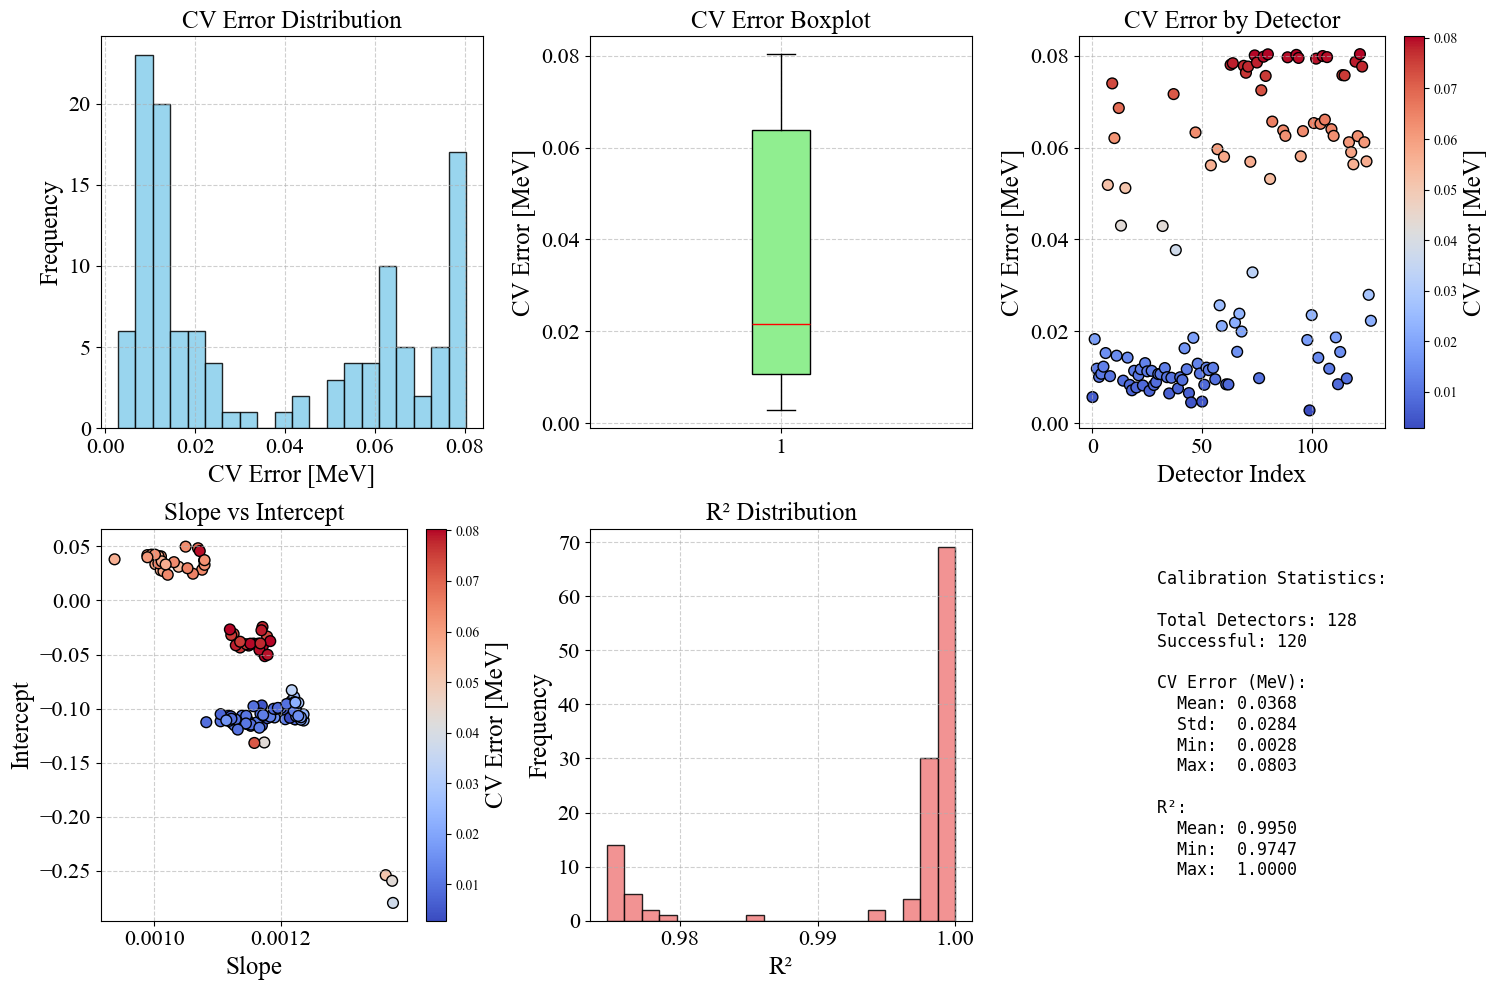

In [8]:
if calibration_results:
    print("📊 Generating calibration quality overview...")
    plot_calibration_quality_overview(calibration_results)
else:
    print("❌ No calibration results to plot.")

## 6. Individual Detector Analysis

Examine calibration details for specific detectors.

🔍 Detailed analysis of sample detectors...

🔬 Detector 0:
   Slope: 0.001141 MeV/channel
   Intercept: -0.109478 MeV
   CV Error: 0.005720 MeV
   R²: 0.999892
   Calibration points: 4


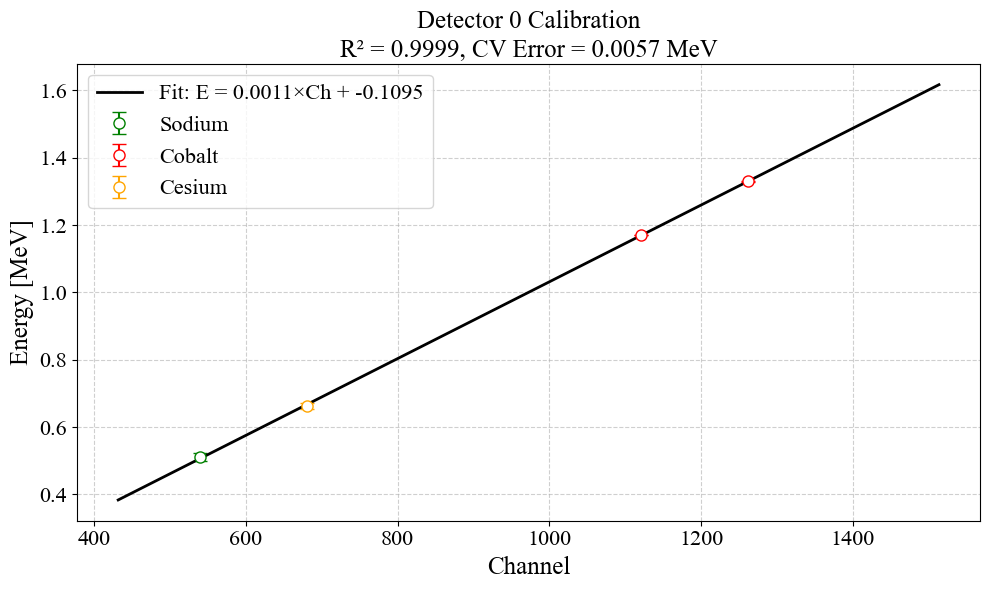


🔬 Detector 1:
   Slope: 0.001135 MeV/channel
   Intercept: -0.112427 MeV
   CV Error: 0.018327 MeV
   R²: 0.999217
   Calibration points: 4


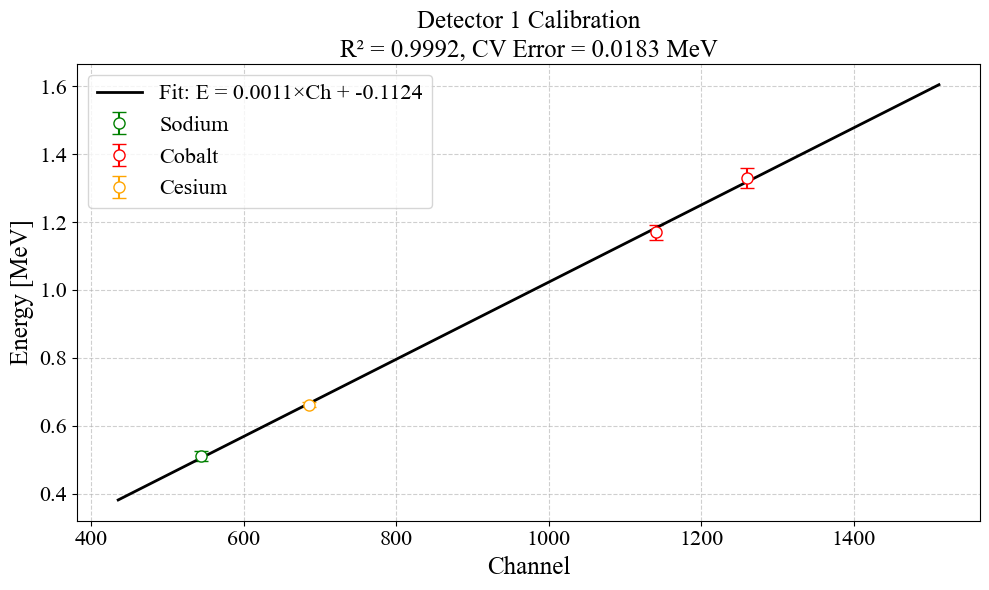


🔬 Detector 2:
   Slope: 0.001139 MeV/channel
   Intercept: -0.106481 MeV
   CV Error: 0.011899 MeV
   R²: 0.999716
   Calibration points: 4


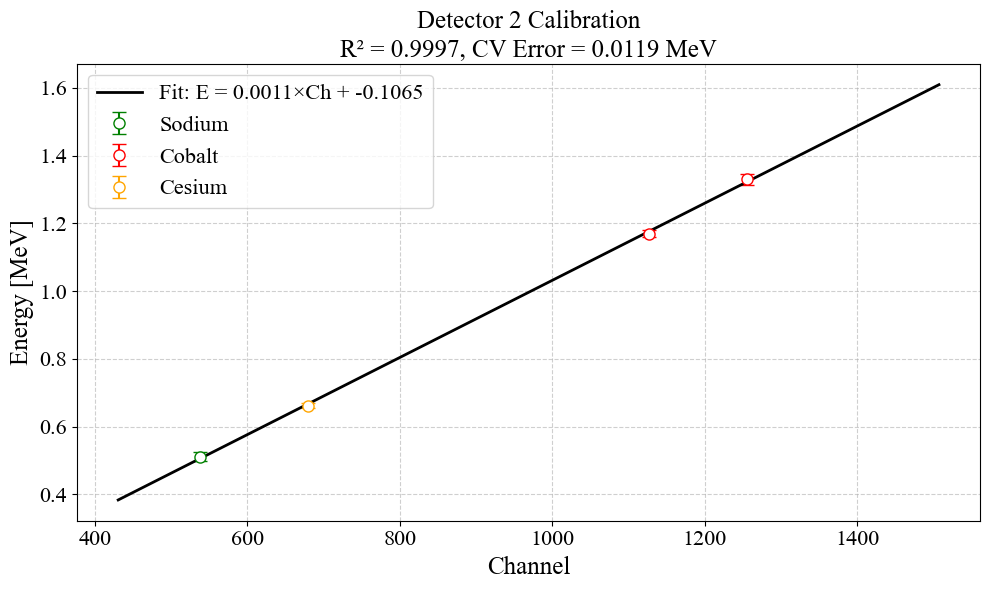

In [9]:
# Analyze a few sample detectors
sample_detectors = [0, 1, 2]  # Change these indices as needed

if calibration_results:
    print("🔍 Detailed analysis of sample detectors...")
    print("=" * 50)
    
    for detector_idx in sample_detectors:
        if detector_idx in calibration_results:
            result = calibration_results[detector_idx]
            calib = result['calibration']
            
            print(f"\n🔬 Detector {detector_idx}:")
            if calib['slope'] is not None:
                print(f"   Slope: {calib['slope']:.6f} MeV/channel")
                print(f"   Intercept: {calib['intercept']:.6f} MeV")
                print(f"   CV Error: {calib['cv_error']:.6f} MeV")
                print(f"   R²: {calib['r_squared']:.6f}")
                print(f"   Calibration points: {calib['n_points']}")
                
                # Plot individual calibration
                plot_single_detector_calibration(detector_idx, result)
            else:
                print(f"   ❌ Calibration failed (insufficient data points)")
        else:
            print(f"\n❌ Detector {detector_idx} not found in results")
else:
    print("❌ No calibration results available for analysis.")

## 7. Source Spectrum Visualization

Visualize combined spectra from all sources for sample detectors.

📈 Combined spectra visualization for detector 1...


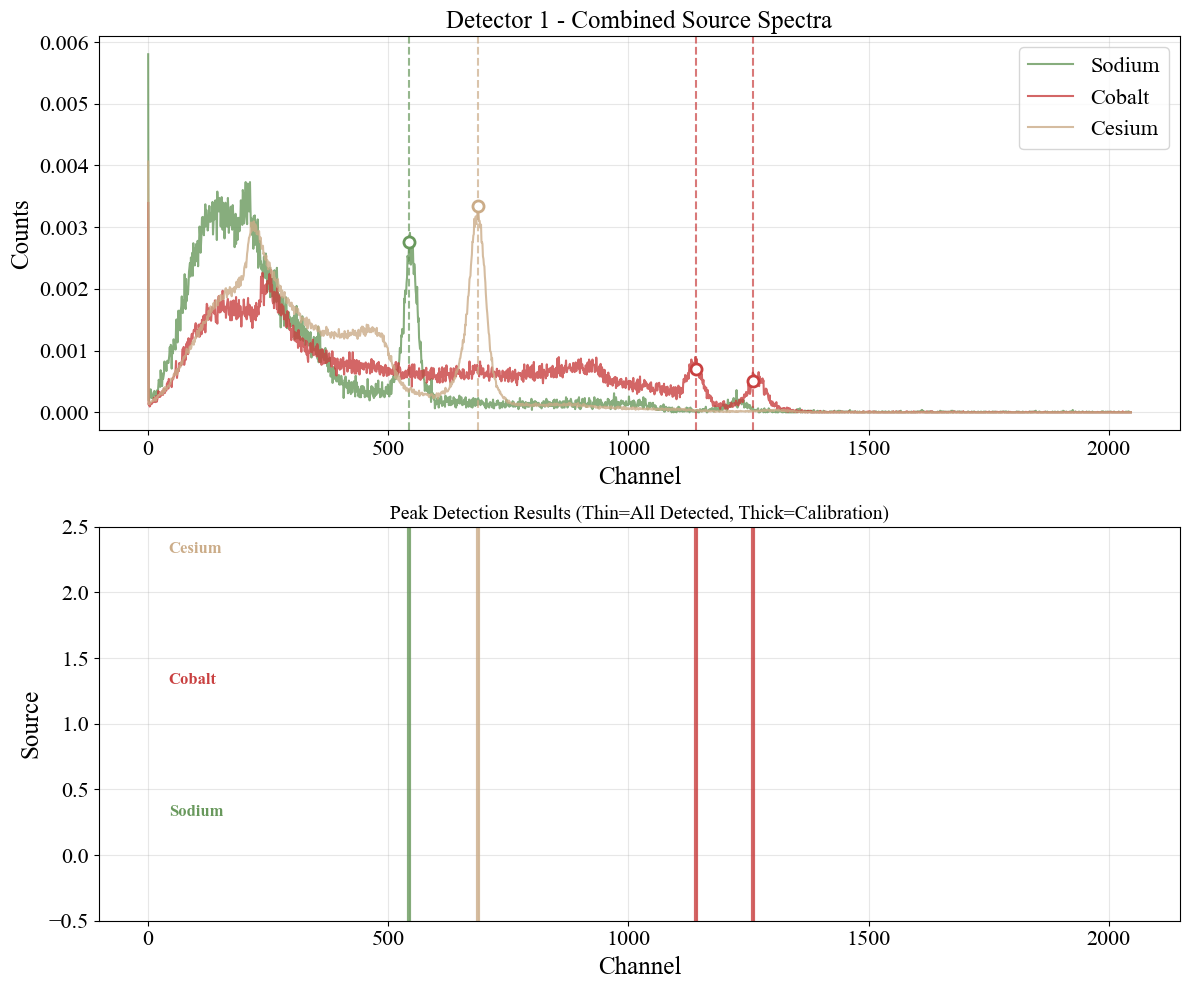

In [10]:
# Plot combined spectra for sample detectors
sample_detector_for_spectra = 1  # Change this as needed

if sources_data:
    print(f"📈 Combined spectra visualization for detector {sample_detector_for_spectra}...")
    
    # Custom colors for sources
    source_colors = {
        "Cesium": "#CBAC88", 
        "Sodium": "#69995D", 
        "Cobalt": "#C94040"
    }
    
    plot_combined_source_spectra(
        sample_detector_for_spectra, 
        sources_data, 
        source_colors
    )
else:
    print("❌ No source data available for spectrum visualization.")

## 8. 3D Energy Space Visualization

Create 3D visualization of spectra in calibrated energy space.

🌐 3D energy space visualization for Cobalt...


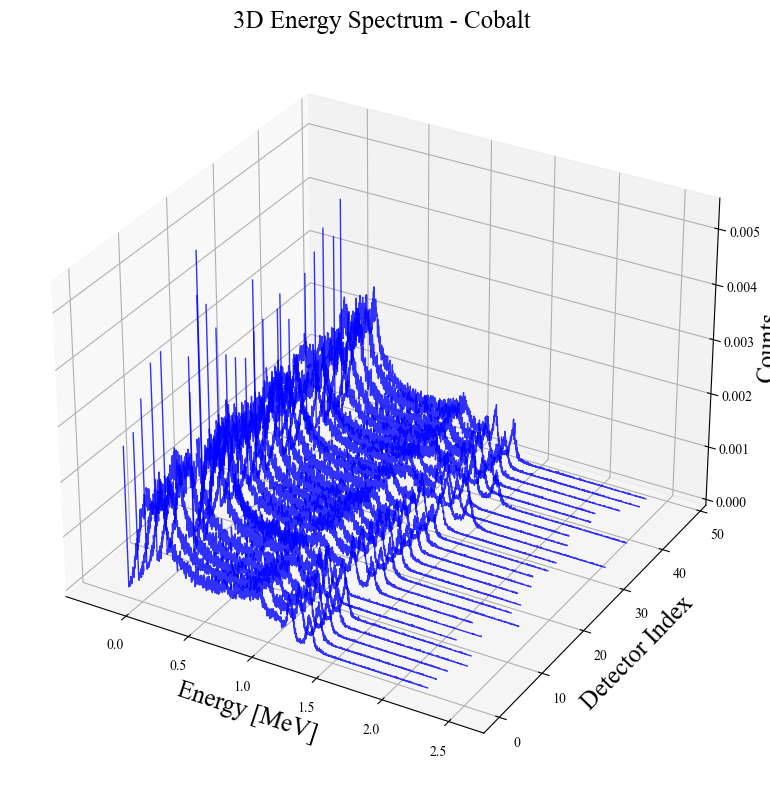

In [17]:
# 3D Energy space visualization
if sources_data and calibration_results:
    # Choose a source for visualization
    visualization_source = "Cobalt"  # Change this to any available source
    
    if visualization_source in sources_data:
        print(f"🌐 3D energy space visualization for {visualization_source}...")
        
        # Use lower threshold for AUC-normalized data
        normalized_threshold = 0.001  # Much lower than original 100 for normalized data
        
        plot_3d_energy_spectrum(
            sources_data,
            calibration_results,
            visualization_source,
            poor_detectors,
            normalized_threshold
        )
    else:
        print(f"❌ Source '{visualization_source}' not available for visualization.")
        print(f"   Available sources: {list(sources_data.keys())}")
else:
    print("❌ Insufficient data for 3D visualization.")

🗺️ 2D energy heatmap for Cobalt...


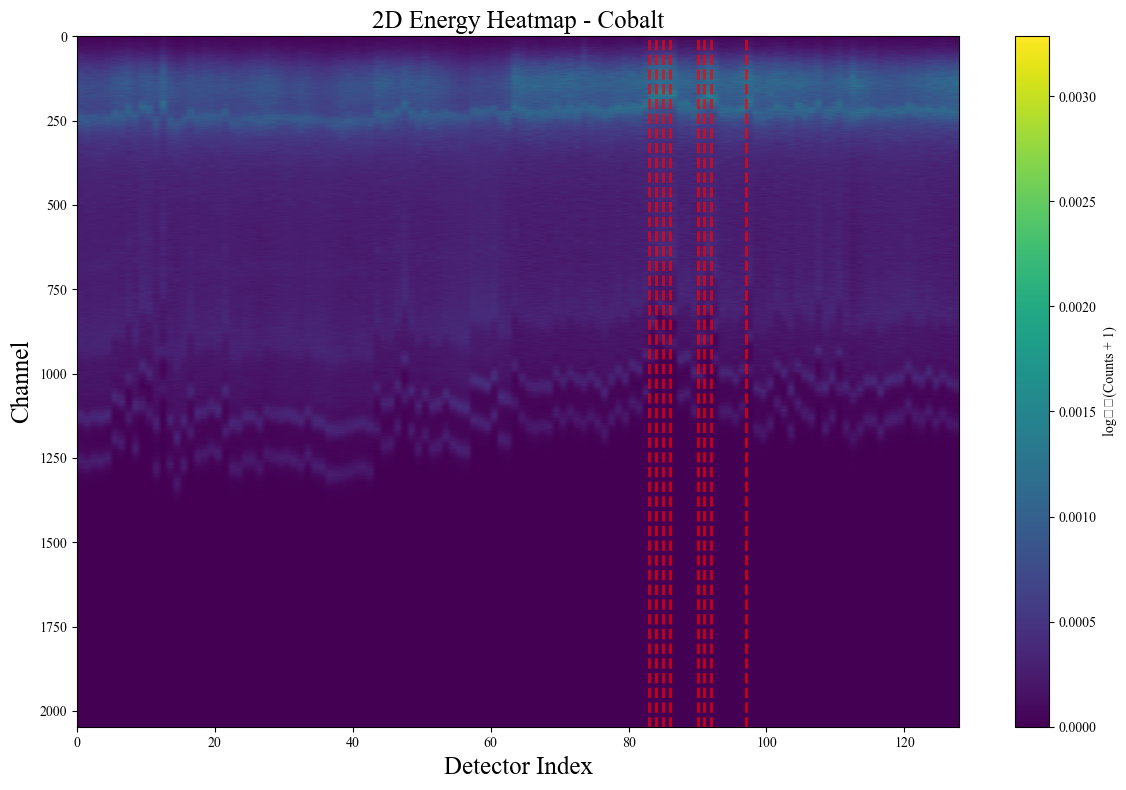

In [20]:
# 2D Energy heatmap visualization
if sources_data and calibration_results:
    visualization_source = "Cobalt"  # Change this to any available source
    
    if visualization_source in sources_data:
        print(f"🗺️ 2D energy heatmap for {visualization_source}...")
        
        # Use lower threshold for AUC-normalized data
        normalized_threshold = 0.001  # Much lower than original for normalized data
        
        plot_2d_energy_heatmap(
            sources_data,
            calibration_results,
            visualization_source,
            poor_detectors,
            normalized_threshold
        )
    else:
        print(f"❌ Source '{visualization_source}' not available for visualization.")
else:
    print("❌ Insufficient data for 2D heatmap visualization.")

## 9. Poor Detector Investigation

Investigate detectors with poor calibration performance in detail.

🚨 Investigating 8 poor detector(s)...

🔍 Detector 83 Analysis:
   CV Error: N/A (insufficient data)
   R²: 1.000000
   Data points: 2
   Peaks detected per source:
     Sodium: 1/1 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


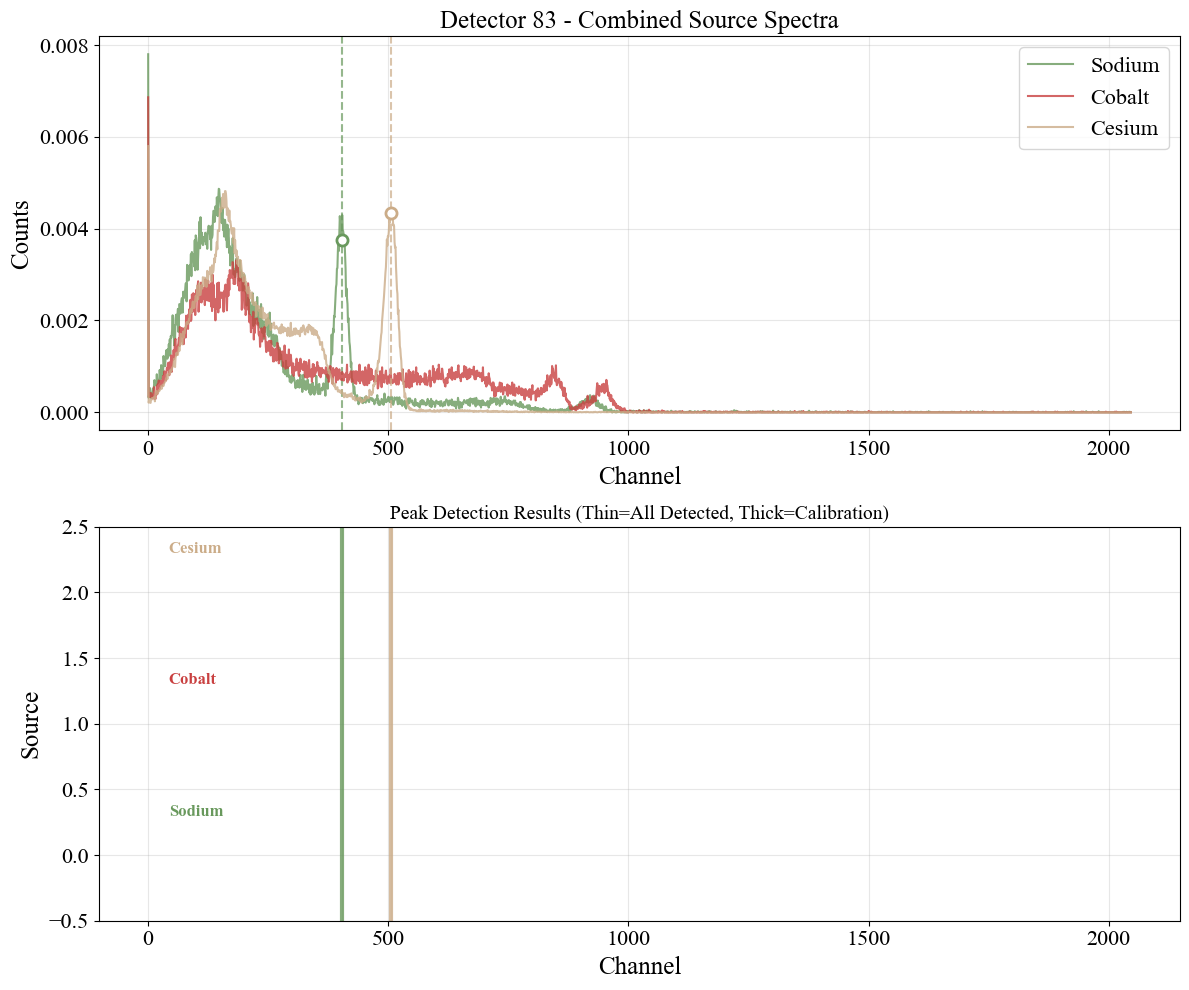

   📈 Calibration curve:


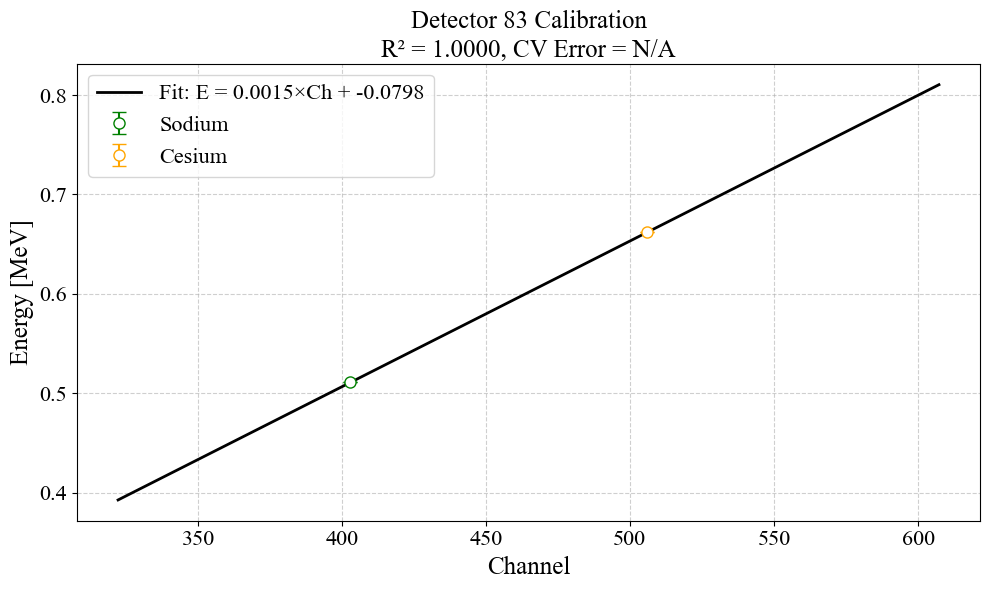


----------------------------------------

🔍 Detector 84 Analysis:
   CV Error: N/A (insufficient data)
   R²: 1.000000
   Data points: 2
   Peaks detected per source:
     Sodium: 1/1 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


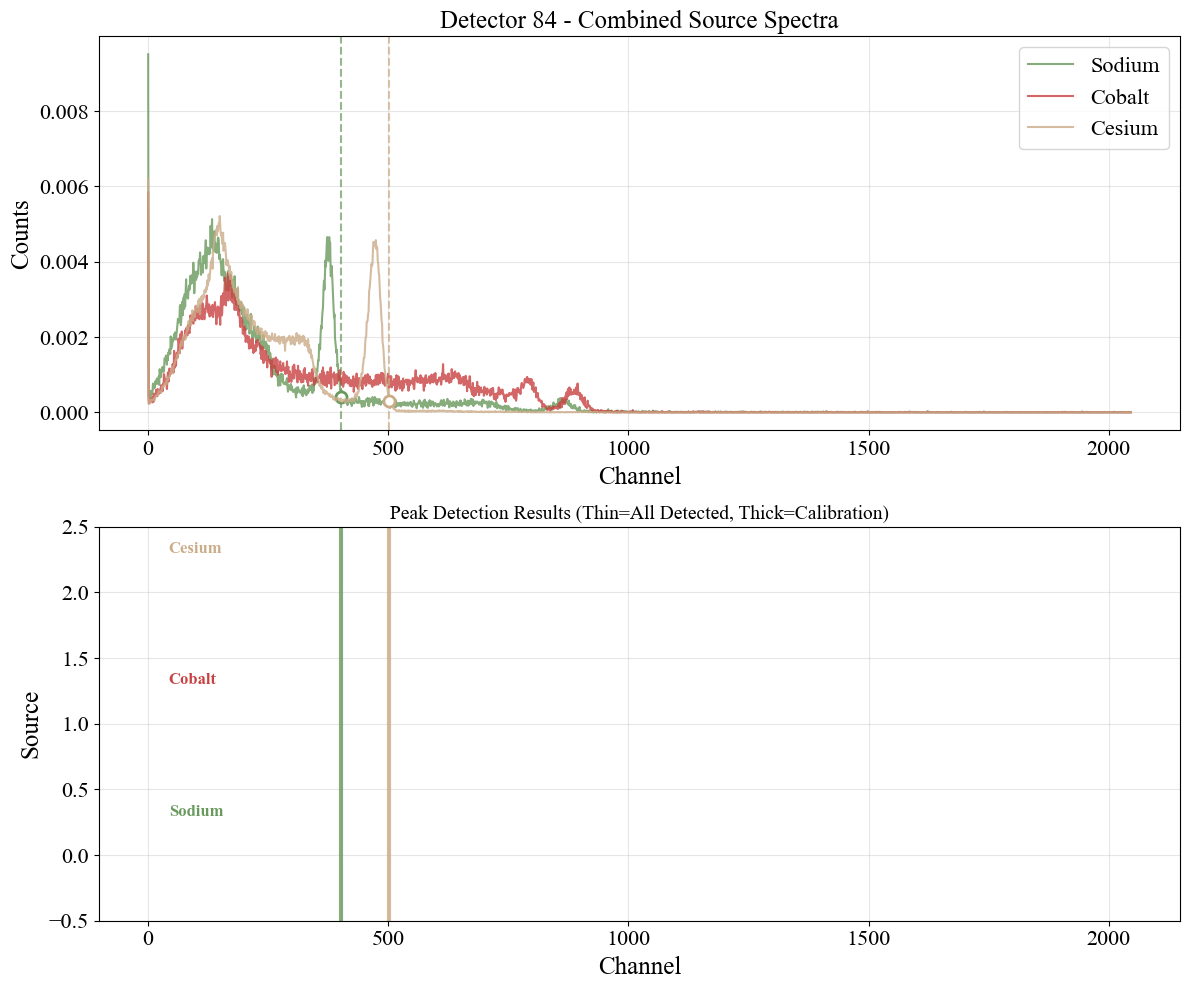

   📈 Calibration curve:


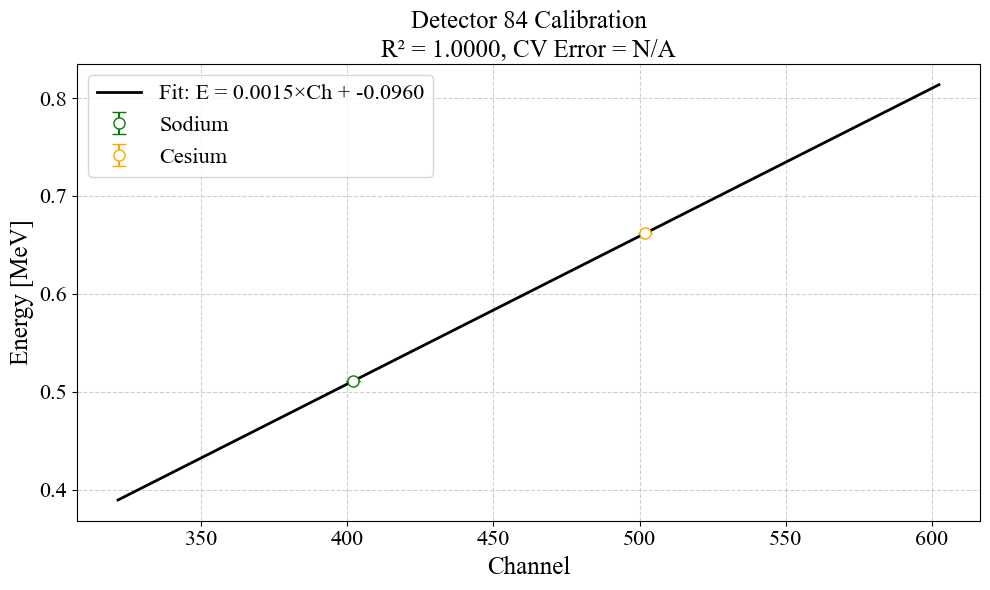


----------------------------------------

🔍 Detector 85 Analysis:
   CV Error: N/A (insufficient data)
   R²: 1.000000
   Data points: 2
   Peaks detected per source:
     Sodium: 1/1 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


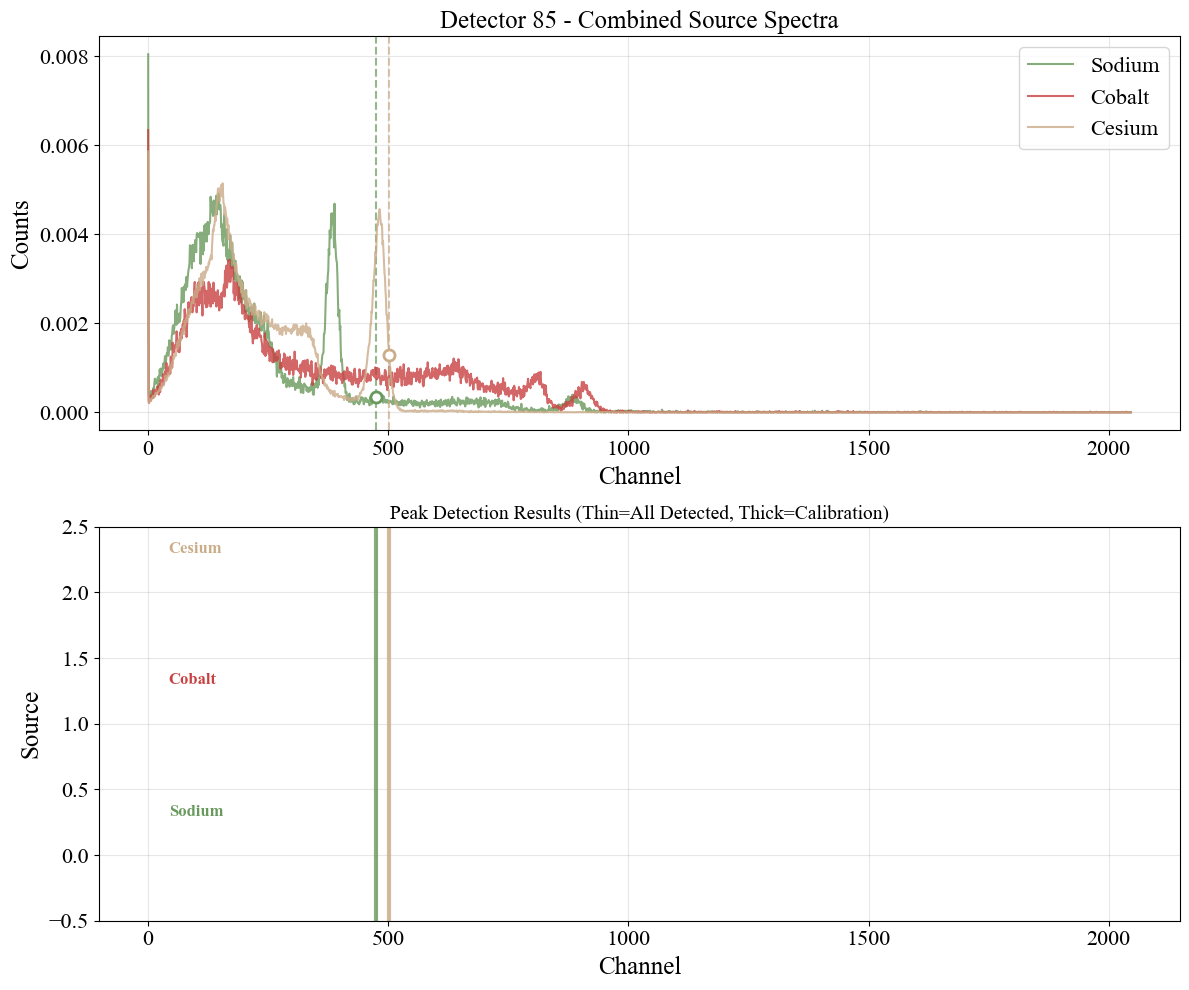

   📈 Calibration curve:


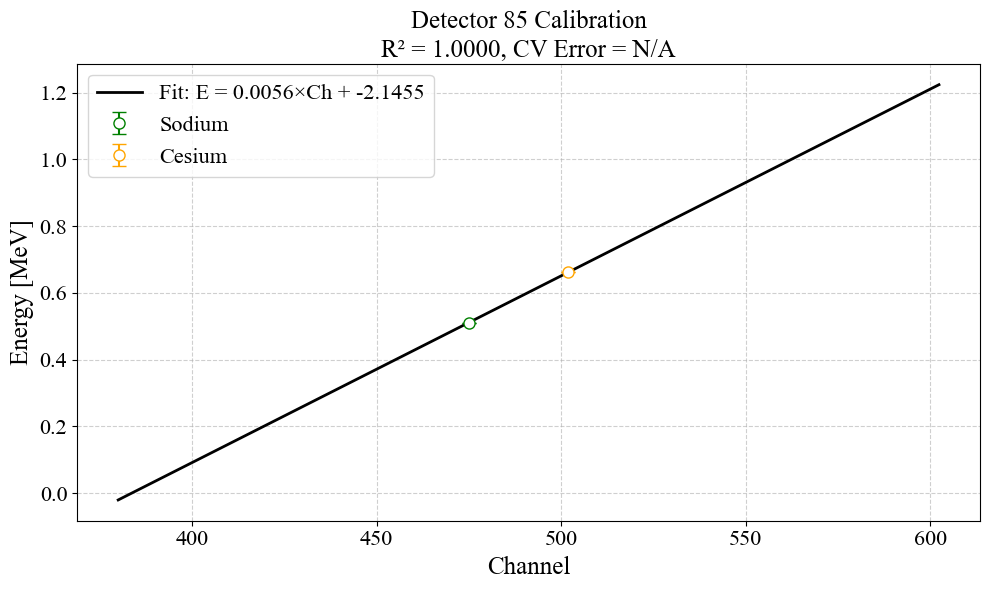


----------------------------------------


In [14]:
# Investigate poor detectors
if poor_detectors:
    print(f"🚨 Investigating {len(poor_detectors)} poor detector(s)...")
    print("=" * 60)
    
    for detector_idx in poor_detectors[:3]:  # Limit to first 3 for notebook clarity
        print(f"\n🔍 Detector {detector_idx} Analysis:")
        
        if detector_idx in calibration_results:
            result = calibration_results[detector_idx]
            calib = result['calibration']
            
            # Handle None values safely
            cv_error = calib['cv_error']
            r_squared = calib['r_squared']
            n_points = calib['n_points']
            
            if cv_error is not None:
                print(f"   CV Error: {cv_error:.6f} MeV")
            else:
                print(f"   CV Error: N/A (insufficient data)")
                
            if r_squared is not None:
                print(f"   R²: {r_squared:.6f}")
            else:
                print(f"   R²: N/A (insufficient data)")
                
            print(f"   Data points: {n_points}")
            
            # Show peaks detected per source
            peaks_per_source = result['peaks_per_source']
            print(f"   Peaks detected per source:")
            for source, peaks in peaks_per_source.items():
                expected = len(expected_energies[source])
                detected = len(peaks)
                print(f"     {source}: {detected}/{expected} peaks")
            
            # Plot spectra for this detector
            print(f"   📊 Spectrum visualization:")
            plot_combined_source_spectra(detector_idx, sources_data)
            
            # Plot calibration if enough points
            if calib['slope'] is not None:
                print(f"   📈 Calibration curve:")
                plot_single_detector_calibration(detector_idx, result)
            else:
                print(f"   ❌ Cannot plot calibration - insufficient data points")
        
        print("\n" + "-" * 40)
else:
    print("✅ No poor detectors found - all detectors meet quality criteria!")

## 10. Export Calibration Results

Save calibration parameters and summary statistics for future use.

In [13]:
# Export calibration results
if calibration_results:
    print("💾 Exporting calibration results...")
    
    # Create calibration summary DataFrame
    export_data = []
    
    for detector_idx, result in calibration_results.items():
        calib = result['calibration']
        export_data.append({
            'detector_index': detector_idx,
            'slope_MeV_per_channel': calib['slope'],
            'intercept_MeV': calib['intercept'],
            'cv_error_MeV': calib['cv_error'],
            'r_squared': calib['r_squared'],
            'n_calibration_points': calib['n_points'],
            'p_value': calib['p_value'],
            'std_error': calib['std_err'],
            'quality_flag': 'good' if detector_idx not in poor_detectors else 'poor'
        })
    
    calibration_df = pd.DataFrame(export_data)
    
    # Save to CSV
    output_file = "detector_calibration_results.csv"
    calibration_df.to_csv(output_file, index=False)
    
    print(f"✅ Calibration results saved to: {output_file}")
    
    # Display summary statistics
    print("\n📋 Calibration Summary:")
    print("=" * 50)
    
    successful_calibrations = calibration_df['slope_MeV_per_channel'].notna().sum()
    good_detectors = (calibration_df['quality_flag'] == 'good').sum()
    
    print(f"Total detectors: {len(calibration_df)}")
    print(f"Successful calibrations: {successful_calibrations}")
    print(f"Good quality detectors: {good_detectors}")
    print(f"Poor quality detectors: {len(poor_detectors)}")
    
    if successful_calibrations > 0:
        valid_df = calibration_df.dropna(subset=['cv_error_MeV'])
        if len(valid_df) > 0:
            print(f"\nCV Error Statistics:")
            print(f"  Mean: {valid_df['cv_error_MeV'].mean():.6f} MeV")
            print(f"  Std:  {valid_df['cv_error_MeV'].std():.6f} MeV")
            print(f"  Min:  {valid_df['cv_error_MeV'].min():.6f} MeV")
            print(f"  Max:  {valid_df['cv_error_MeV'].max():.6f} MeV")
        
        valid_r2 = calibration_df.dropna(subset=['r_squared'])
        if len(valid_r2) > 0:
            print(f"\nR² Statistics:")
            print(f"  Mean: {valid_r2['r_squared'].mean():.6f}")
            print(f"  Min:  {valid_r2['r_squared'].min():.6f}")
            print(f"  Max:  {valid_r2['r_squared'].max():.6f}")
    
    # Display first few rows
    print(f"\n🔢 Sample calibration data:")
    display(calibration_df.head(10))
    
else:
    print("❌ No calibration results to export.")

💾 Exporting calibration results...
✅ Calibration results saved to: detector_calibration_results.csv

📋 Calibration Summary:
Total detectors: 128
Successful calibrations: 126
Good quality detectors: 80
Poor quality detectors: 48

CV Error Statistics:
  Mean: 0.332733 MeV
  Std:  0.734202 MeV
  Min:  0.005321 MeV
  Max:  4.127522 MeV

R² Statistics:
  Mean: 0.988930
  Min:  0.932450
  Max:  1.000000

🔢 Sample calibration data:


,detector_index,slope_MeV_per_channel,intercept_MeV,cv_error_MeV,r_squared,n_calibration_points,p_value,std_error,quality_flag
0,0,0.000923,0.012597,NaN,1.000000,2,0.000000,0.000000,poor
1,1,0.001154,-0.120362,0.026304,0.998010,4,0.000995,0.000036,good
2,2,0.001133,-0.101148,0.010100,0.999801,4,0.000099,0.000011,good
3,3,0.001150,-0.121123,0.012617,0.999686,4,0.000157,0.000014,good
4,4,0.001171,-0.125414,0.015458,0.999443,4,0.000279,0.000020,good
5,5,0.001224,-0.118414,0.027075,0.998454,4,0.000773,0.000034,good
6,6,0.001337,-0.193372,0.076985,0.981977,4,0.009052,0.000128,good
7,7,0.001159,-0.045552,0.074573,0.976634,4,0.011752,0.000127,good
8,8,0.001040,0.048879,0.069661,0.999019,3,0.019943,0.000033,good
9,9,0.001212,-0.053778,2.816327,0.971453,3,0.108081,0.000208,poor


## 11. Summary

Final summary of the calibration process and recommendations.

In [21]:
print("📊 CALIBRATION SUMMARY")
print("=" * 60)

if sources_data:
    print(f"\n✅ Sources processed: {len(sources_data)}")
    print(f"   📊 AUC normalization applied to all spectra for source comparability")
    for source_name, data in sources_data.items():
        n_channels, n_detectors = data['spectra'].shape
        print(f"   {source_name}: {n_channels} channels, {n_detectors} detectors")
    
    if calibration_results:
        successful = sum(1 for r in calibration_results.values() 
                        if r['calibration']['slope'] is not None)
        print(f"\n🎯 Calibration success rate: {successful}/{len(calibration_results)} "
              f"({100*successful/len(calibration_results):.1f}%)")
        
        if poor_detectors:
            print(f"\n⚠️  Poor detectors: {len(poor_detectors)} "
                  f"({100*len(poor_detectors)/len(calibration_results):.1f}%)")
            print(f"   Detector indices: {poor_detectors[:10]}")  # Show first 10
            if len(poor_detectors) > 10:
                print(f"   ... and {len(poor_detectors)-10} more")
        else:
            print(f"\n✅ All detectors meet quality threshold!")
        
        print(f"\n📁 Output files generated:")
        print(f"   📄 detector_calibration_results.csv")
        print(f"   📊 Various calibration plots (displayed above)")
        
        print(f"\n🔍 Recommendations:")
        if poor_detectors:
            print(f"   🔧 Investigate poor detectors for hardware issues")
            print(f"   📊 Consider excluding poor detectors from analysis")
        
        cv_errors = [r['calibration']['cv_error'] for r in calibration_results.values()
                    if r['calibration']['cv_error'] is not None]
        if cv_errors:
            mean_error = np.mean(cv_errors)
            if mean_error > 0.02:
                print(f"   📈 Consider using more calibration sources for better accuracy")
            if mean_error < 0.01:
                print(f"   ✨ Excellent calibration accuracy achieved!")
        
        print(f"\n🚀 Next steps:")
        print(f"   📊 Use calibration parameters for energy analysis")
        print(f"   🔄 Repeat calibration periodically to check stability")
        print(f"   📋 Document calibration procedure and results")
        print(f"   🔬 AUC-normalized spectra are ready for quantitative comparison")
    else:
        print(f"\n❌ Calibration failed - check data and parameters")
else:
    print(f"\n❌ No data processed - check file paths and configuration")

print(f"\n" + "=" * 60)
print(f"🎉 Calibration analysis complete!")

📊 CALIBRATION SUMMARY

✅ Sources processed: 3
   📊 AUC normalization applied to all spectra for source comparability
   Sodium: 2047 channels, 128 detectors
   Cobalt: 2047 channels, 128 detectors
   Cesium: 2047 channels, 128 detectors

🎯 Calibration success rate: 128/128 (100.0%)

⚠️  Poor detectors: 8 (6.2%)
   Detector indices: [83, 84, 85, 86, 90, 91, 92, 97]

📁 Output files generated:
   📄 detector_calibration_results.csv
   📊 Various calibration plots (displayed above)

🔍 Recommendations:
   🔧 Investigate poor detectors for hardware issues
   📊 Consider excluding poor detectors from analysis
   📈 Consider using more calibration sources for better accuracy

🚀 Next steps:
   📊 Use calibration parameters for energy analysis
   🔄 Repeat calibration periodically to check stability
   📋 Document calibration procedure and results
   🔬 AUC-normalized spectra are ready for quantitative comparison

🎉 Calibration analysis complete!
